In [ ]:
%clear all

from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])

visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = 2#len(actions_dict)

# Exploration factor
epsilon = 0.1





In [ ]:
import random
random.choice([0, 1, 2, 3])

3

reward= -0.04
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Epoch: 000/14999 | Loss: 0.0038 0.0030 0.0037 0.0036 | Episodes: 114 | Win count: 0 | Win rate: 0.000 | time: 25.5 seconds
Epoch: 001/14999 | Loss: 0.1436 0.1820 0.0035 0.0019 | Episodes: 105 | Win count: 0 | Win rate: 0.000 | time: 49.9 seconds
Epoch: 002/14999 | Loss: 0.0057 0.0044 0.1383 0.0019 | Episodes: 14 | Win count: 1 | Win rate: 0.000 | time: 53.0 seconds
Epoch: 003/14999 | Loss: 0.0146 0.1301 0.0093 0.2455 | Episodes: 76 | Win count: 2

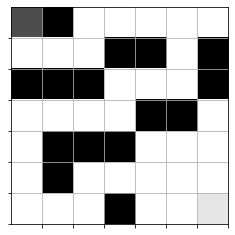

In [ ]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

maze = [
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
]

qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)


qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)


def play_game(model_l,model_r,model_u,model_d, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    pa=0
    while True:
        prev_envstate = envstate
        # get next action
        ql = model_l.predict(prev_envstate)
        qr = model_r.predict(prev_envstate)
        qu = model_u.predict(prev_envstate)
        qd = model_d.predict(prev_envstate)
   
        al = np.argmax(ql[0])
        ar = np.argmax(qr[0])
        au = np.argmax(qu[0])
        ad = np.argmax(qd[0])

        #print('Here--------------->',al,ar,au,ad)

        if   (al==1 and ar==0): 
                    if ((au==0 and ad==0) or (au==1 and ad==1)):
                        action=0
                    elif (au==0 and ad==1):
                        action = random.choice([0,3])
                    elif (au==1 and ad==0):
                        action = random.choice([0,1])      
 
        elif (au==1 and ad==0):
                    if ((al==0 and ar==0) or (al==1 and ar==1)):
                        action=1        
                    elif (al==0 and ar==1):
                        action = random.choice([1,2])
                    elif (al==1 and ar==0):
                        action = random.choice([1,0])      

        elif (al==0 and ar==1):
                    if ((au==0 and ad==0) or (au==1 and ad==1)):
                        action=2
                    elif (au==0 and ad==1):
                        action = random.choice([2,3])
                    elif (au==1 and ad==0):
                        action = random.choice([2,1])      
 
        elif (au==0 and ad==1) :
                    if ((al==0 and ar==0) or (al==1 and ar==1)):
                        action=3
                    elif (al==0 and ar==1):
                        action = random.choice([3,2])
                    elif (al==1 and ar==0):
                        action = random.choice([3,0])      
 
        else:
                    action = random.choice([0, 1, 2, 3]) 
                    if   (action==0):
                      al=1;ar=0;au=0;ad=0;
                    elif (action==1):
                      al=0;ar=0;au=1;ad=0;
                    elif (action==2):
                      al=0;ar=1;au=0;ad=0;    
                    elif (action==3):
                      al=0;ar=0;au=0;ad=1;

        #pa=action


        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False



def completion_check(model_l, model_r, model_u, model_d, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model_l, model_r, model_u, model_d, qmaze, cell):
            return False
    return True



class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        #print(self.model.predict(envstate))
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets


def qtrain(model_l,model_r, model_u, model_d, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)

    max_memoryl = opt.get('max_memory', 1000)
    max_memoryr = opt.get('max_memory', 1000)
    max_memoryu = opt.get('max_memory', 1000)
    max_memoryd = opt.get('max_memory', 1000)

    data_sizel = opt.get('data_size', 50)
    data_sizer = opt.get('data_size', 50)
    data_sizeu = opt.get('data_size', 50)
    data_sized = opt.get('data_size', 50)

    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience_l = Experience(model_l, max_memory=max_memoryl)
    experience_r = Experience(model_r, max_memory=max_memoryr)
    experience_u = Experience(model_u, max_memory=max_memoryu)
    experience_d = Experience(model_d, max_memory=max_memoryd)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1
    wrdb=[]
    edb=[]
    epdb=[]  
    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        pa=0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
                if (action==0):
                  al=1;ar=0;au=0;ad=0;
                elif (action==1):
                  al=0;ar=0;au=1;ad=0;
                elif (action==2):
                  al=0;ar=1;au=0;ad=0;    
                elif (action==3):
                  al=0;ar=0;au=0;ad=1;
            else:
                al = np.argmax(experience_l.predict(prev_envstate))
                ar = np.argmax(experience_r.predict(prev_envstate))
                au = np.argmax(experience_u.predict(prev_envstate))
                ad = np.argmax(experience_d.predict(prev_envstate))
 
                if   (al==1 and ar==0): 
                    if ((au==0 and ad==0) or (au==1 and ad==1)):
                        action=0
                    elif (au==0 and ad==1):
                        action = random.choice([0,3])
                    elif (au==1 and ad==0):
                        action = random.choice([0,1])      
 
                elif (au==1 and ad==0):
                    if ((al==0 and ar==0) or (al==1 and ar==1)):
                        action=1        
                    elif (al==0 and ar==1):
                        action = random.choice([1,2])
                    elif (al==1 and ar==0):
                        action = random.choice([1,0])      

                elif (al==0 and ar==1):
                    if ((au==0 and ad==0) or (au==1 and ad==1)):
                        action=2
                    elif (au==0 and ad==1):
                        action = random.choice([2,3])
                    elif (au==1 and ad==0):
                        action = random.choice([2,1])      
 
                elif (au==0 and ad==1) :
                    if ((al==0 and ar==0) or (al==1 and ar==1)):
                        action=3
                    elif (al==0 and ar==1):
                        action = random.choice([3,2])
                    elif (al==1 and ar==0):
                        action = random.choice([3,0])      
 
                else:
                    action = random.choice(valid_actions) ##pa
                    if (action==0):
                      al=1;ar=0;au=0;ad=0;
                    elif (action==1):
                      al=0;ar=0;au=1;ad=0;
                    elif (action==2):
                      al=0;ar=1;au=0;ad=0;    
                    elif (action==3):
                      al=0;ar=0;au=0;ad=1;
            #print(al,ar,au,ad)
            pa=action
            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode_l = [prev_envstate, al, reward, envstate, game_over]
            episode_r = [prev_envstate, ar, reward, envstate, game_over]
            episode_u = [prev_envstate, au, reward, envstate, game_over]
            episode_d = [prev_envstate, ad, reward, envstate, game_over]
            
            experience_l.remember(episode_l)
            experience_r.remember(episode_r)
            experience_u.remember(episode_u)
            experience_d.remember(episode_d)
            n_episodes += 1

            # Train neural network model
            inputs_l, targets_l = experience_l.get_data(data_size=data_sizel)
            hl = model_l.fit(
                inputs_l,
                targets_l,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss_l = model_l.evaluate(inputs_l, targets_l, verbose=0)

            # Train neural network model
            inputs_r, targets_r = experience_r.get_data(data_size=data_sizer)
            hr = model_r.fit(
                inputs_r,
                targets_r,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss_r = model_r.evaluate(inputs_r, targets_r, verbose=0)

            # Train neural network model
            inputs_u, targets_u = experience_u.get_data(data_size=data_sizeu)
            hu = model_u.fit(
                inputs_u,
                targets_u,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss_u = model_u.evaluate(inputs_u, targets_u, verbose=0)
            
            # Train neural network model
            inputs_d, targets_d = experience_d.get_data(data_size=data_sized)
            hd = model_d.fit(
                inputs_d,
                targets_d,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss_d = model_d.evaluate(inputs_d, targets_d, verbose=0)


        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        wrdb.append(sum(win_history))
        edb.append(epoch)
        epdb.append(n_episodes)
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} {:.4f} {:.4f} {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss_l, loss_r, loss_u, loss_d, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model_l, model_r, model_u, model_d, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            
            np.save('/content/drive/My Drive/db/dqn/maze/dqn/wrdb_cs',wrdb)
            np.save('/content/drive/My Drive/db/dqn/maze/dqn/edb_cs',edb)
            np.save('/content/drive/My Drive/db/dqn/maze/dqn/epdb_cs',epdb)
            break

"""
    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds
"""
# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)


def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])
from google.colab import drive
drive.mount('/content/drive')

qmaze = Qmaze(maze)
show(qmaze)

model_l = build_model(maze)
model_r = build_model(maze)
model_u = build_model(maze)
model_d = build_model(maze)

qtrain(model_l,model_r,model_u,model_d, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


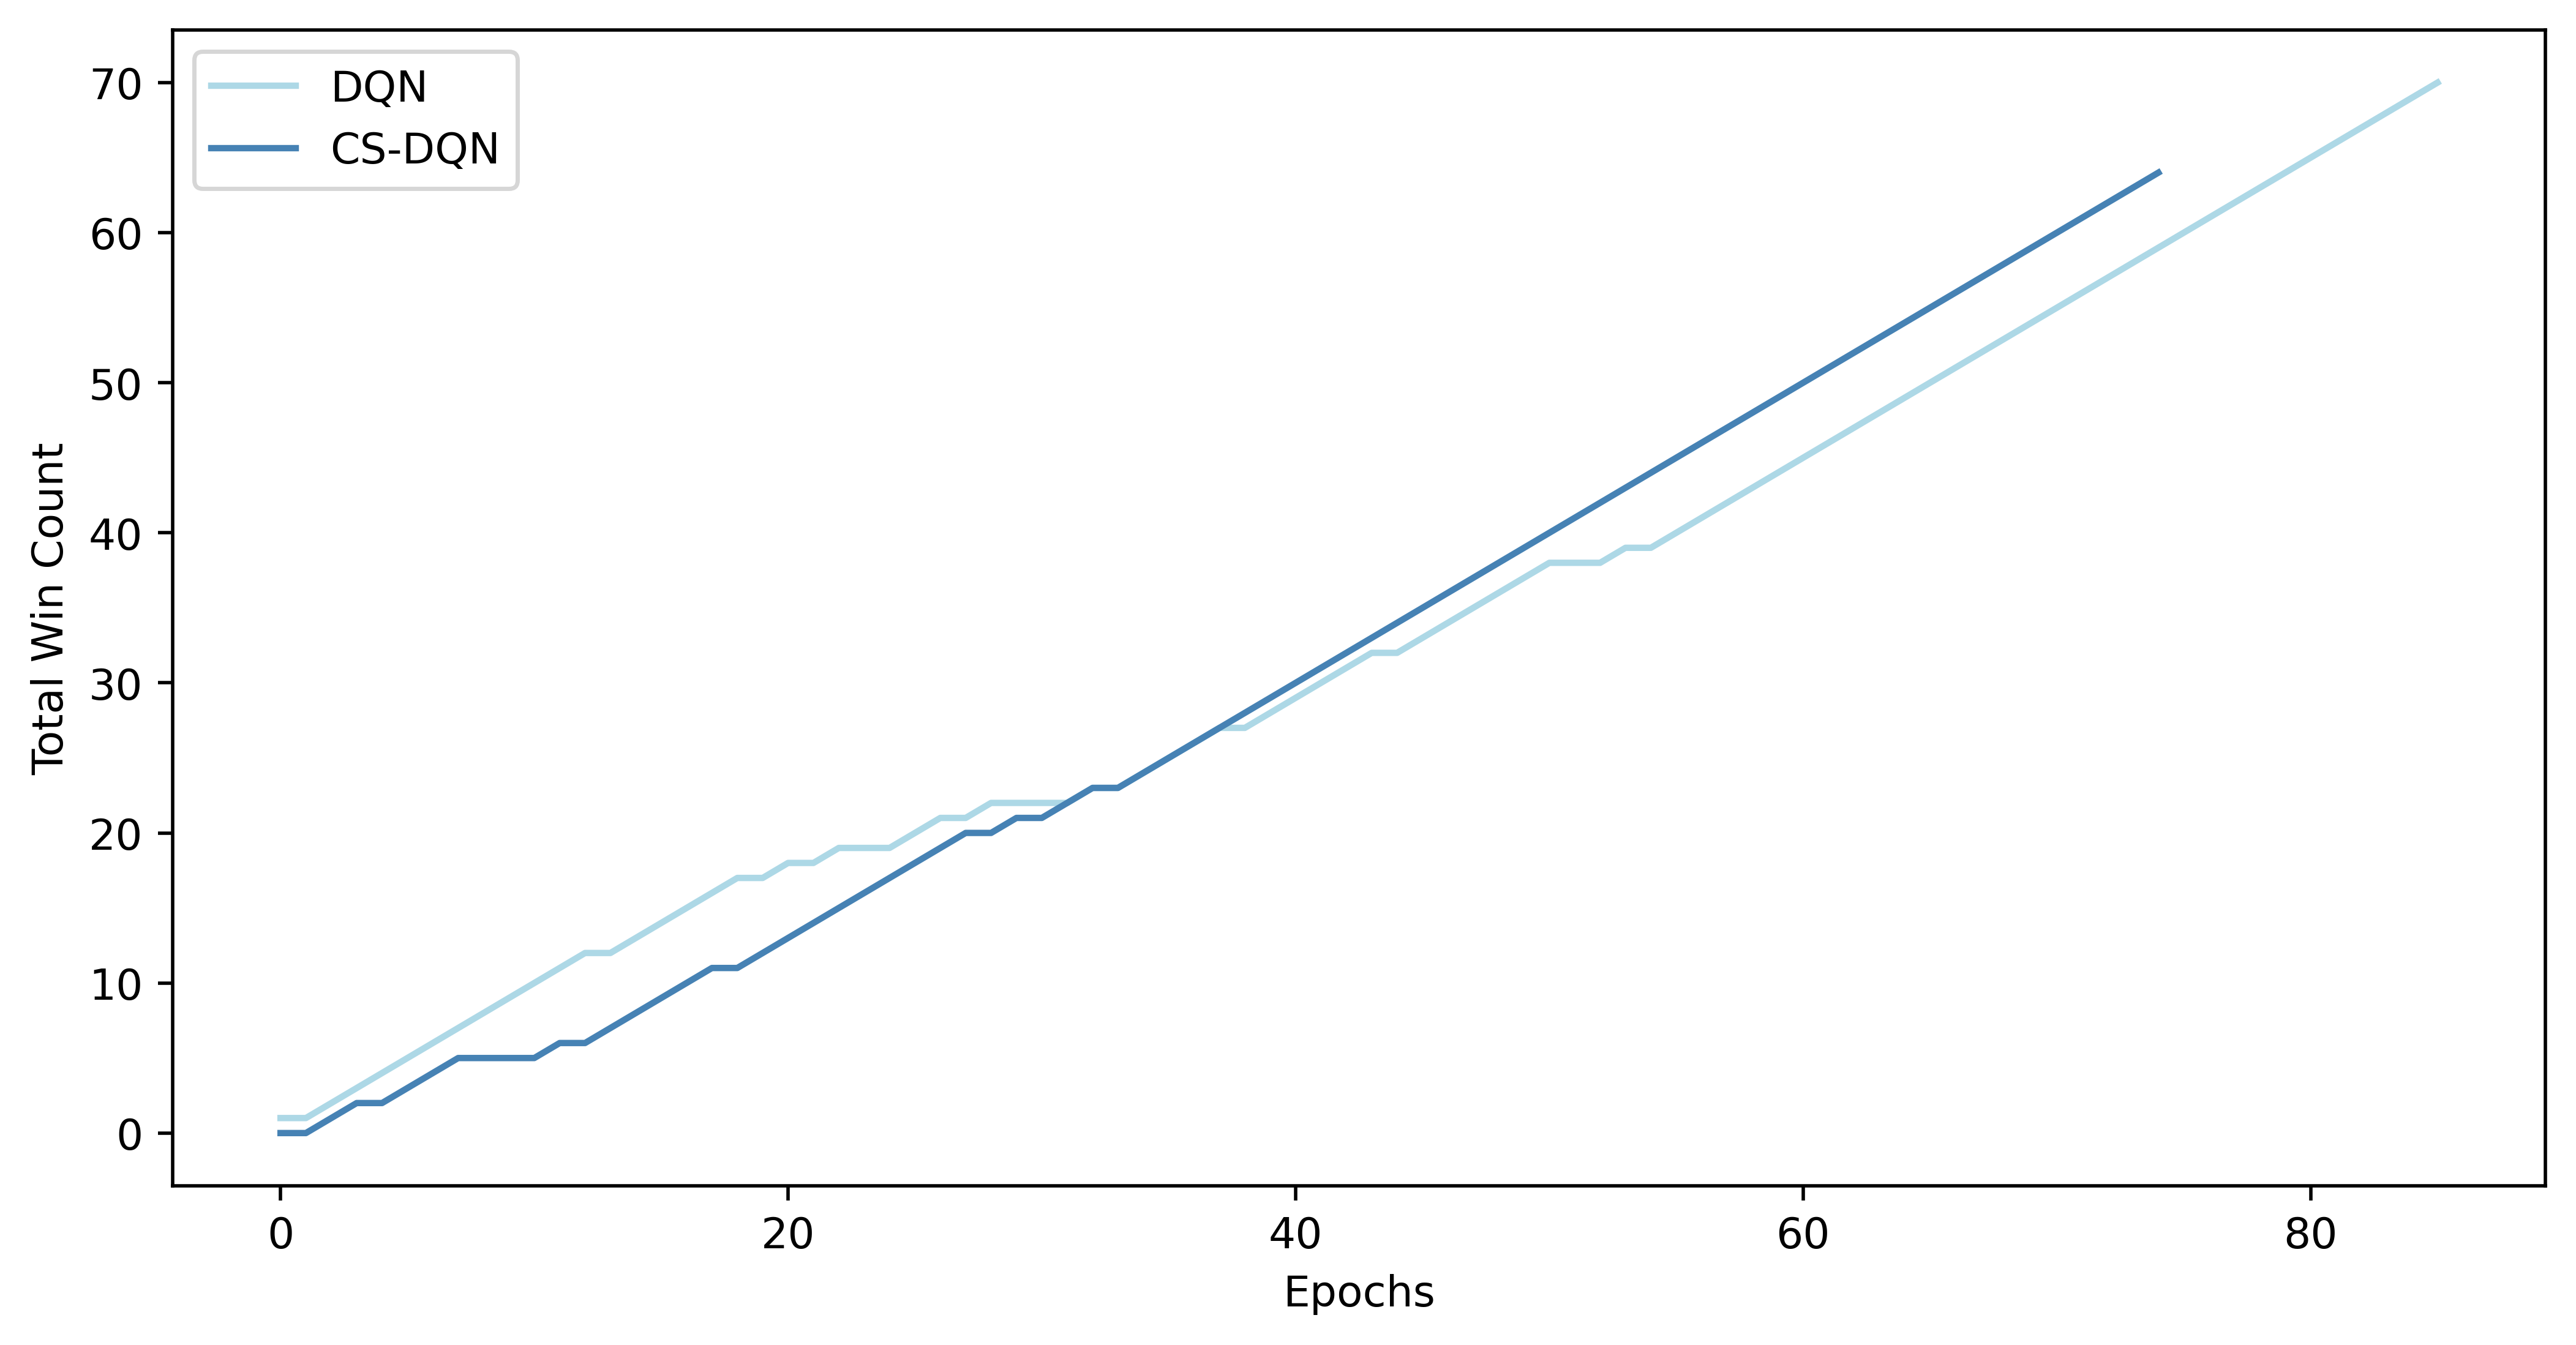

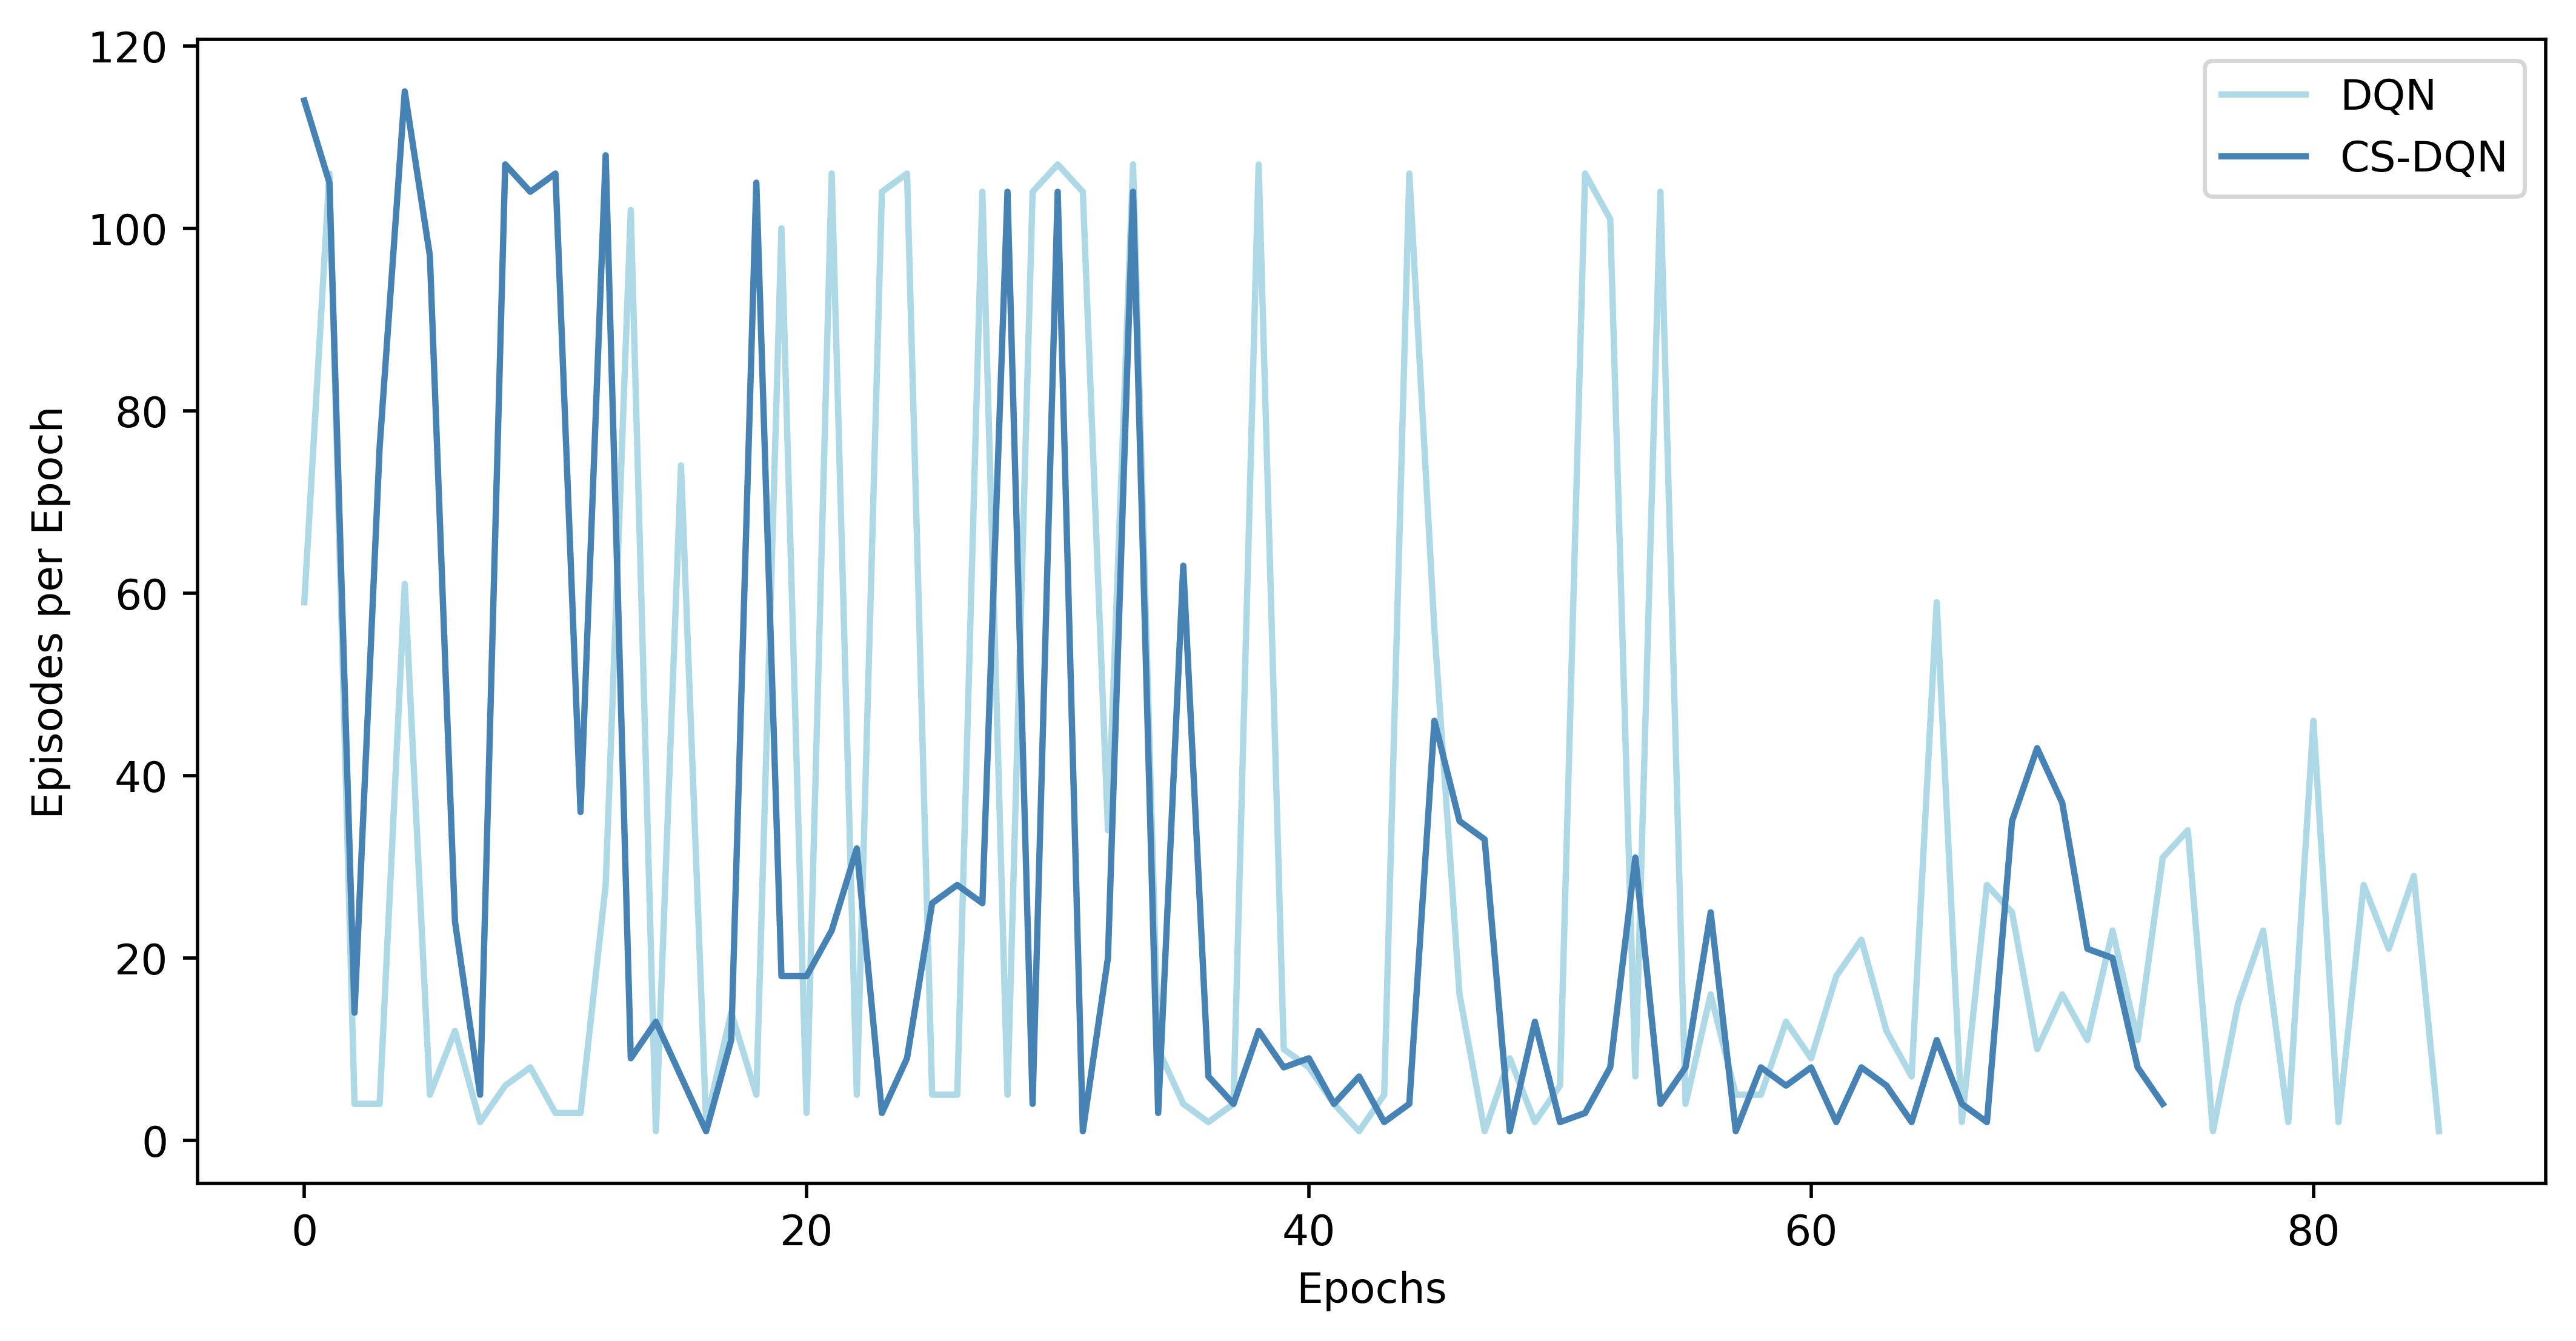

In [1]:
from google.colab import drive
drive.mount('/content/drive')


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1

fig = plt.figure(figsize=(10,5),dpi=500)

wr_old=np.load('/content/drive/My Drive/db/dqn/maze/dqn/wrdb.npy')
wr_new=np.load('/content/drive/My Drive/db/dqn/maze/dqn/wrdb_cs.npy')
edb_old=np.load('/content/drive/My Drive/db/dqn/maze/dqn/edb.npy')
edb_new=np.load('/content/drive/My Drive/db/dqn/maze/dqn/edb_cs.npy')
epdb_old=np.load('/content/drive/My Drive/db/dqn/maze/dqn/epdb.npy')
epdb_new=np.load('/content/drive/My Drive/db/dqn/maze/dqn/epdb_cs.npy')

plt.plot(wr_old, color= 'lightblue',label='DQN')
plt.plot(wr_new, color='steelblue',label='CS-DQN')
plt.ylabel('Total Win Count')
plt.xlabel('Epochs')
plt.legend()
plt.show()


fig = plt1.figure(figsize=(10,5),dpi=500)
plt1.plot(epdb_old, color= 'lightblue',label='DQN')
plt1.plot(epdb_new, color='steelblue',label='CS-DQN')
plt1.ylabel('Episodes per Epoch')
plt1.xlabel('Epochs')
plt1.legend()
plt1.show()